# Text Detection

In [11]:
import cv2
import easyocr
import pytesseract
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import numpy as np

#### Input

In [12]:
target_image_path = 'images/testcase3.png'

target_img = cv2.imread(target_image_path)

#### easyocr implementation - not as good as tesseract

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Signal
Signal
Signal
Signal
Signal
Assigned Task Door System Logic
Device
Device
Assigned Task funnyTypeChanged4
Device
Assigned Task Sensor Open Button
Assigned Task Sensor Close Button
Assigned Task Door System Logic
Assigned Task Sensor Open Button
Assigned Task Sensor Close Button
Device aDeviceType
Device
Device


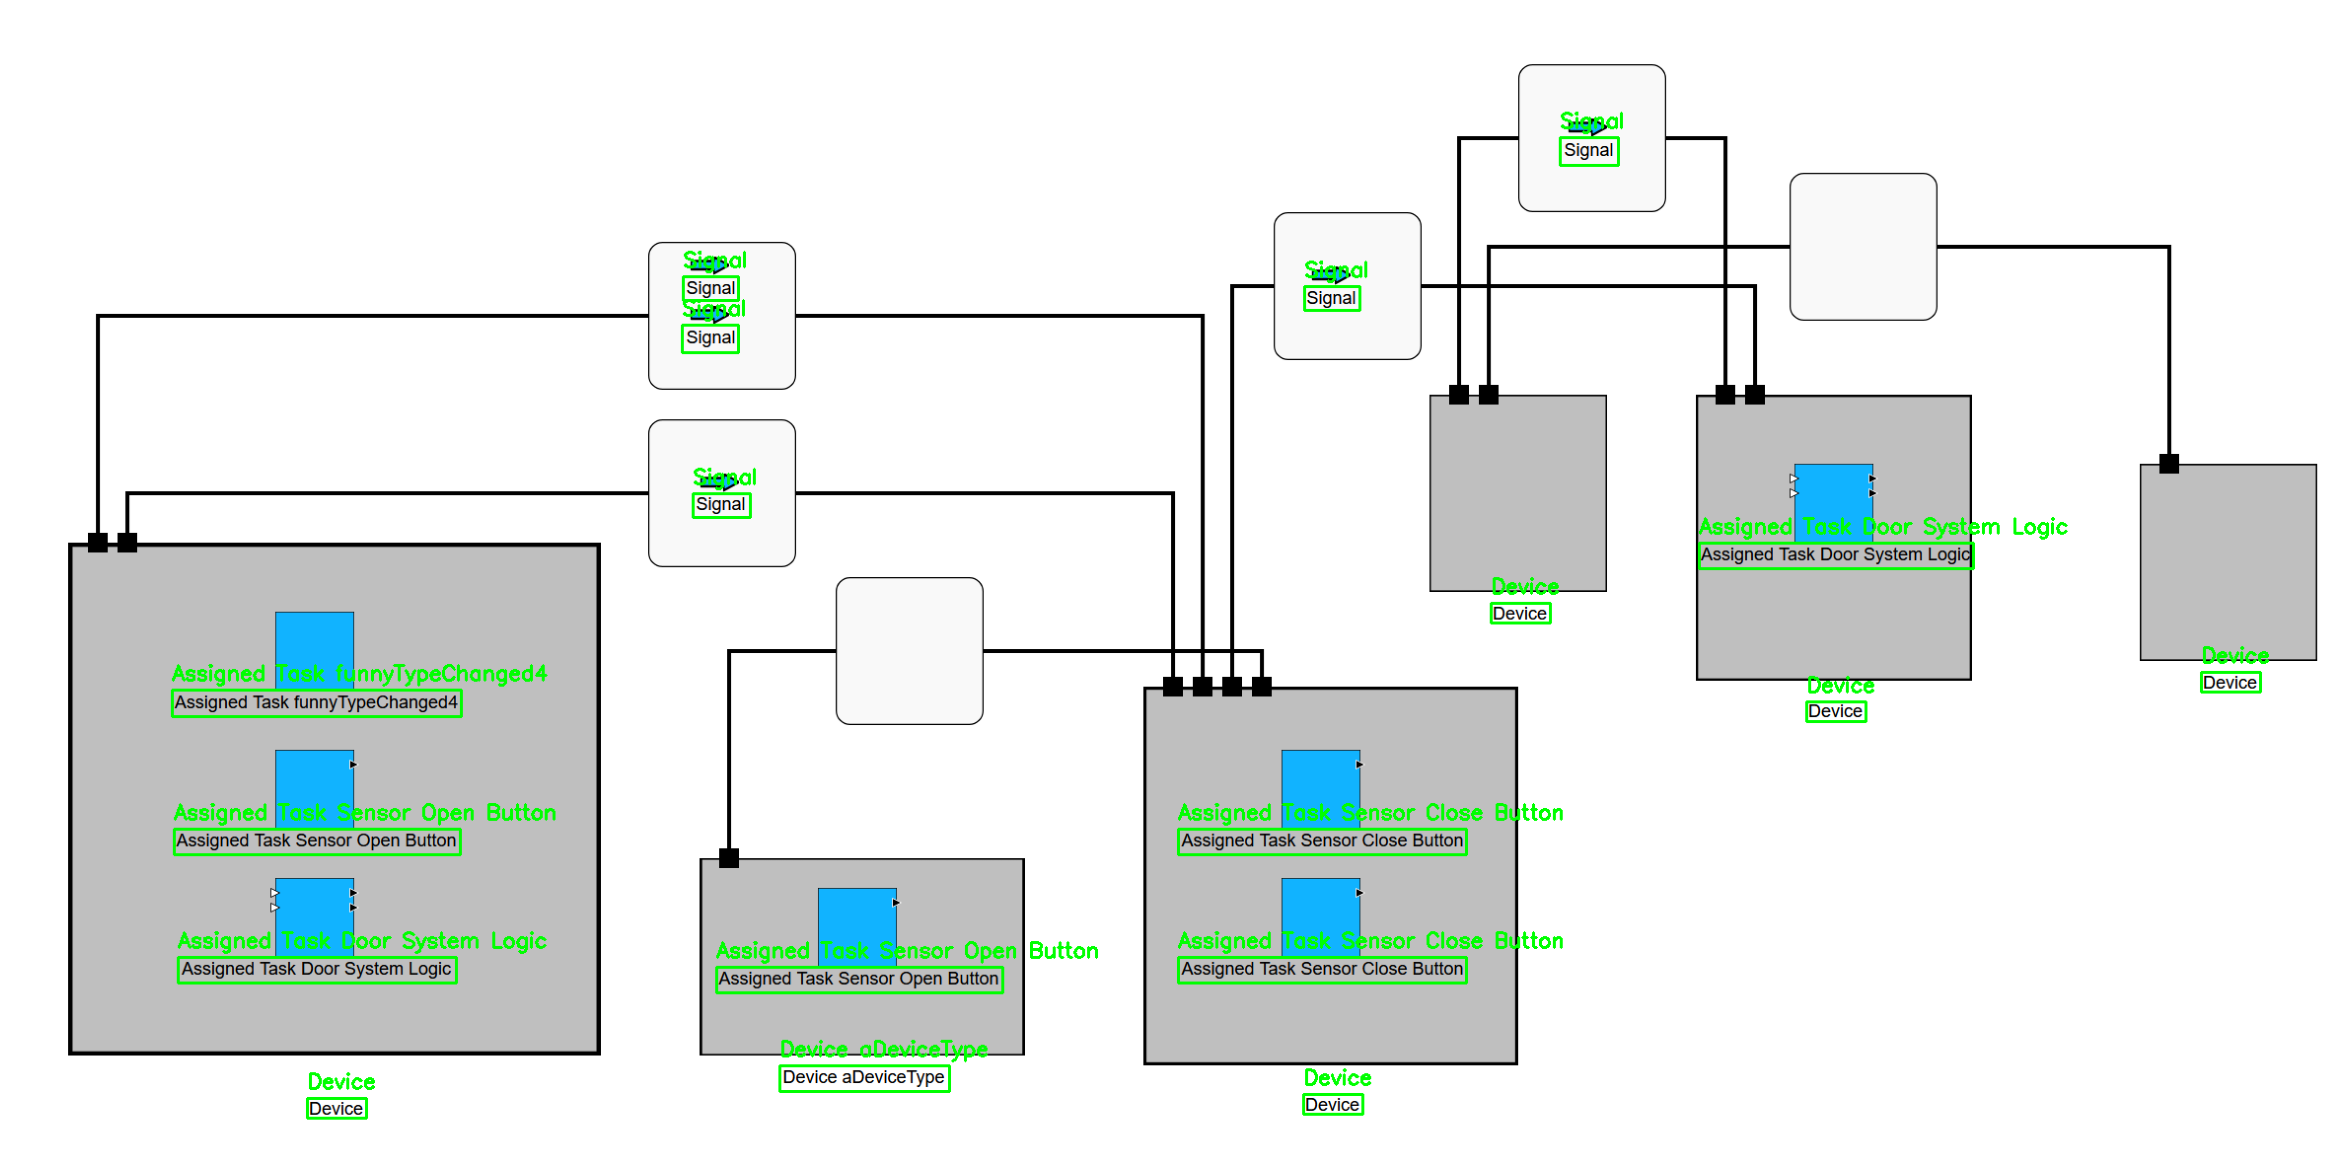

In [13]:
easyocr_img = target_img.copy()
# Create an OCR reader object
reader = easyocr.Reader(['en'])

# Read text from an image
result = reader.readtext(easyocr_img)

# Print the extracted text
for detection in result:
    print(detection[1])

# Draw the detected text on the image
for detection in result:
    top_left = tuple(detection[0][0])
    bottom_right = tuple(detection[0][2])
    text = detection[1]
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    color = (0, 255, 0)  # Green color
    thickness = 2

    # Draw rectangle around the text
    cv2.rectangle(easyocr_img, top_left, bottom_right, color, thickness)

    # Put the text above the rectangle
    cv2.putText(easyocr_img, text, (top_left[0], top_left[1] - 10), font, font_scale, color, thickness)

# Display the image with detected text inside the Jupyter Notebook

plt.figure(figsize=(150, 15))
plt.imshow(cv2.cvtColor(easyocr_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### pytesseract implementation - works even with rotated text

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
22,5,1,3,1,1,1,689,250,40,19,90.139206,=>
26,5,1,4,1,1,1,686,275,49,17,96.808060,Signal
30,5,1,5,1,1,1,689,300,40,19,90.139206,=>
34,5,1,6,1,1,1,686,325,49,17,96.808060,Signal
38,5,1,7,1,1,1,699,470,40,19,90.647316,=>
42,5,1,8,1,1,1,696,494,49,17,96.808060,Signal
62,5,1,13,1,1,1,784,1075,54,13,93.306084,Device
63,5,1,13,1,1,2,844,1075,103,17,88.058342,aDeviceType
67,5,1,14,1,1,1,1314,1103,54,13,96.756935,Device
71,5,1,15,1,1,1,304,1107,54,13,96.756935,Device


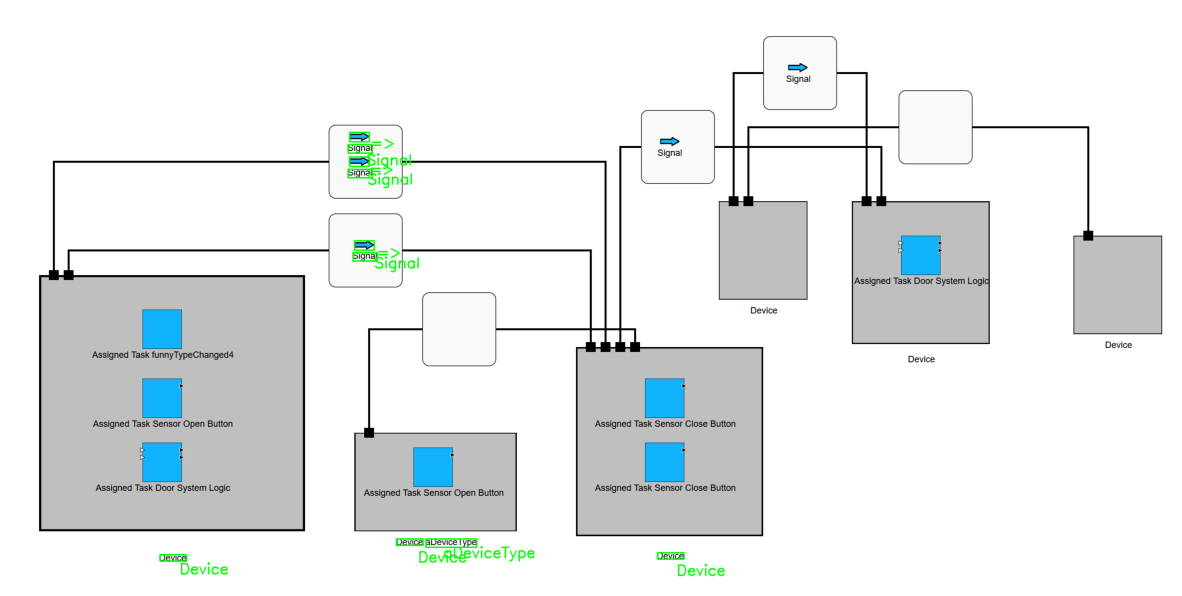

In [14]:
pytesseract_img = target_img.copy()
data = pytesseract.image_to_data(pytesseract_img)
# Convert the data to a pandas DataFrame
data_list = [row.split('\t') for row in data.split('\n')]
df = pd.DataFrame(data_list[1:], columns=data_list[0])

# Filter the DataFrame to only include rows with a confidence level greater than 70 and non-empty text
df = df[(df['conf'].astype(float) > 70) & (df['text'].str.strip() != '')]

# Display the DataFrame
display(df)

for index, row in df.iterrows():
    (x, y, w, h) = (int(row['left']), int(row['top']), int(row['width']), int(row['height']))
    text = row['text']
    cv2.rectangle(pytesseract_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    deviation_x = np.random.randint(15, 26)
    deviation_y = np.random.randint(30, 51)
    cv2.putText(pytesseract_img, text, (x + 20 + deviation_x, y + deviation_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(pytesseract_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### connecting text bounding boxes

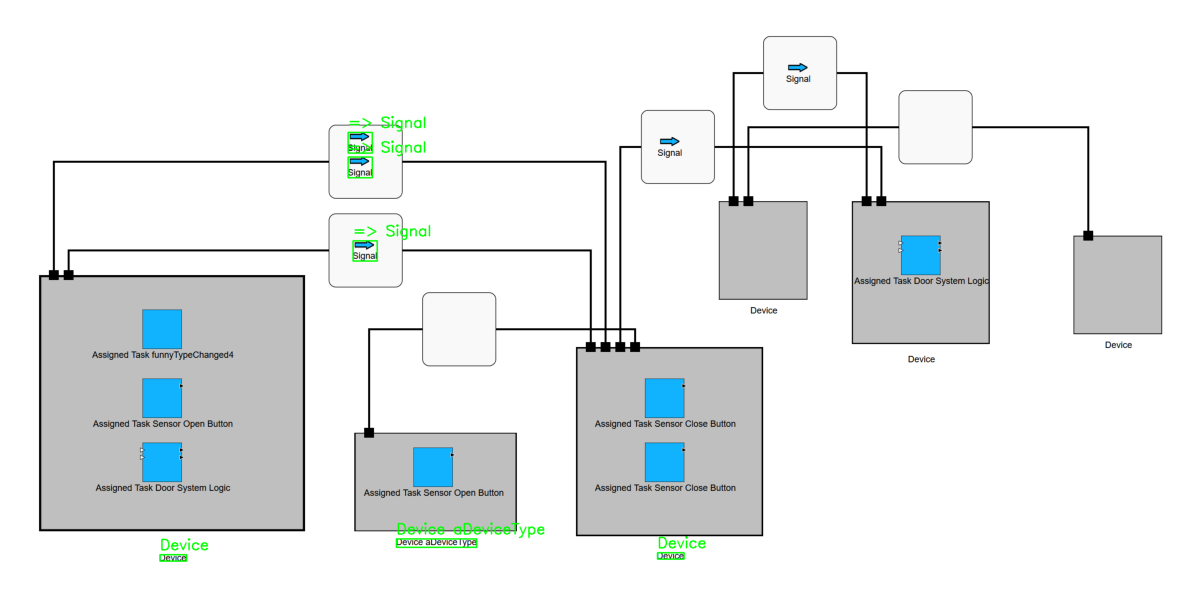

In [15]:
# Function to check if two bounding boxes are close enough to be merged
def is_close(box1, box2, threshold=90):
    (x1, y1, w1, h1) = box1
    (x2, y2, w2, h2) = box2
    return abs(x1 - x2) < threshold and abs(y1 - y2) < threshold

# Function to merge two bounding boxes
def merge_boxes(box1, box2):
    (x1, y1, w1, h1) = box1
    (x2, y2, w2, h2) = box2
    x = min(x1, x2)
    y = min(y1, y2)
    w = max(x1 + w1, x2 + w2) - x
    h = max(y1 + h1, y2 + h2) - y
    return (x, y, w, h)

# Extract bounding boxes and texts from the DataFrame
bounding_boxes = []
texts = []
for index, row in df.iterrows():
    (x, y, w, h) = (int(row['left']), int(row['top']), int(row['width']), int(row['height']))
    text = row['text']
    bounding_boxes.append((x, y, w, h))
    texts.append(text)

# Merge nearby bounding boxes
merged_boxes = []
merged_texts = []
skip_indices = set()
for i in range(len(bounding_boxes)):
    if i in skip_indices:
        continue
    box1 = bounding_boxes[i]
    text1 = texts[i]
    for j in range(i + 1, len(bounding_boxes)):
        if j in skip_indices:
            continue
        box2 = bounding_boxes[j]
        text2 = texts[j]
        if is_close(box1, box2):
            merged_box = merge_boxes(box1, box2)
            merged_text = text1 + " " + text2
            merged_boxes.append(merged_box)
            merged_texts.append(merged_text)
            skip_indices.add(i)
            skip_indices.add(j)
            break
    else:
        merged_boxes.append(box1)
        merged_texts.append(text1)

# Draw the merged bounding boxes and texts on the image
for (x, y, w, h), text in zip(merged_boxes, merged_texts):
    cv2.rectangle(target_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(target_img, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Display the image with merged text bounding boxes
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()